**Name:** Andrew Moore

**USC ID:** 7583780941

**Github Username:** drewm8080

# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications.inception_v3 import preprocess_input

from google.colab import drive
drive.mount('/content/drive')
from keras.models import Sequential
from keras.layers import Activation, Dense,Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
import keras

from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize 
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import cv2
from imutils import paths
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1
**Transfer Learning in Images**

1. In this step, I first split the data into three folders randomly and uploaded it locally to increase speed of the models. I then applied data augmentation using ImageDataGenerator. 
2. Next, I tested ResNet50, EfficientNetB0,and VGG16 by removing the last layer, freezing all the previous layers, and then adding a RELU layer,softmax, BatchNormalization, and dropout of 20%. I applied an ADAM Optimizer and minimized multiclass cross entropy. I used training and validation data for this step. 
3. I reported the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for training and testing data. 

In [ ]:
# creating a split of the data randomly

# !pip install split-folders
# import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/dsci552_finalproject/images/Sport Images', output="/content/drive/MyDrive/dsci552_finalproject/images", seed=1337, ratio=(.7, 0.15,0.15)) 

In [ ]:
!unzip train.zip -d train
!unzip val.zip -d val
!unzip test.zip -d test

Archive:  train.zip
replace train/train/baseball/00000036.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  val.zip
replace val/val/fencing/00000041.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  test.zip
replace test/test/basketball/00000208.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Data Augmentation for Images

In [ ]:
# reference: https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# reference:  https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
# reference : https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
seed_train_validation = 1 # Must be same for train_ds and val_ds



train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.1,1.0],rotation_range=30, horizontal_flip=True, vertical_flip=True,brightness_range=[0.1,1.5],width_shift_range = 0.1,height_shift_range = 0.1)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


train_ds = train_datagen.flow_from_directory(
directory ="/content/train/train",
target_size = (224, 224),
batch_size =5,
shuffle = False,
seed = seed_train_validation)

validation_ds = validation_datagen.flow_from_directory(
directory ="/content/val/val",
target_size = (224, 224),
batch_size =5,
shuffle = False,
seed = seed_train_validation)

test_ds = test_datagen.flow_from_directory(
directory ="/content/test/test",
target_size = (224, 224),
batch_size =5,
shuffle = False,
seed = seed_train_validation)


Found 2289 images belonging to 5 classes.
Found 486 images belonging to 5 classes.
Found 496 images belonging to 5 classes.


### VGG16 Model

In [ ]:
# reference: https://stackoverflow.com/questions/55335228/how-to-remove-the-last-layer-from-a-pre-trained-model-i-have-tried-model-layers
# reference: https://keras.io/api/layers/activations/
# reference: https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f

vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
model = Sequential()

# # getting all layers but last one 

# # Freezing the laters  
for layer in vgg16_model.layers:
    layer.trainable = False

    

x = vgg16_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x) 
added_vgg16_model = Model(inputs=vgg16_model.input, outputs=x)

# Make sure you have frozen the correct layers
print("Layers that are frozen vs not")
print('')
print('')
for i, layer in enumerate(added_vgg16_model.layers):
    print(i, layer.name, layer.trainable)

# # setting up the optimization of our weights 
added_vgg16_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr= 5e-5), metrics=["accuracy"])

Layers that are frozen vs not


0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_1 True
20 batch_normalization_1 True
21 dense_2 True
22 dropout_1 True
23 dense_3 True


In [ ]:
added_vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#https://keras.io/api/callbacks/early_stopping/

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=12)

history_vgg16_model = added_vgg16_model.fit_generator(train_ds,
                    validation_data = validation_ds,
                    epochs=100,callbacks=[callback]
)

<ipython-input-14-1ff070c179c8>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg16_model = added_vgg16_model.fit_generator(train_ds,


Epoch 1/100
458/458 [==============================] - 40s 81ms/step - loss: 5.9790 - accuracy: 0.3010 - val_loss: 17.6266 - val_accuracy: 0.2634
Epoch 2/100
458/458 [==============================] - 38s 84ms/step - loss: 2.0760 - accuracy: 0.4526 - val_loss: 8.2419 - val_accuracy: 0.3663
Epoch 3/100
458/458 [==============================] - 37s 81ms/step - loss: 1.2099 - accuracy: 0.5400 - val_loss: 6.8175 - val_accuracy: 0.4280
Epoch 4/100
458/458 [==============================] - 37s 81ms/step - loss: 1.0871 - accuracy: 0.5946 - val_loss: 7.6636 - val_accuracy: 0.4444
Epoch 5/100
458/458 [==============================] - 37s 81ms/step - loss: 1.0558 - accuracy: 0.6064 - val_loss: 6.3870 - val_accuracy: 0.5062
Epoch 6/100
458/458 [==============================] - 37s 81ms/step - loss: 1.0958 - accuracy: 0.6033 - val_loss: 6.5493 - val_accuracy: 0.5206
Epoch 7/100
458/458 [==============================] - 37s 81ms/step - loss: 1.0663 - accuracy: 0.6243 - val_loss: 6.9980 - val_a

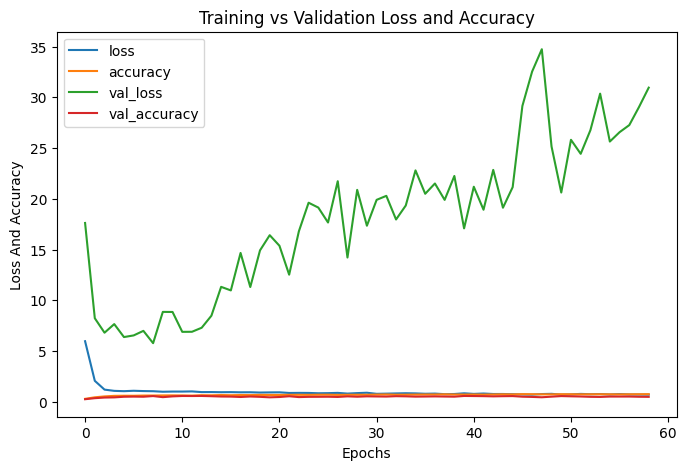

In [ ]:
# reference: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
pd.DataFrame(history_vgg16_model.history).plot(figsize=(8,5))
plt.xlabel('Epochs')
plt.ylabel('Loss And Accuracy')
plt.title('Training vs Validation Loss and Accuracy')
plt.show()


100/100 [==============================] - 3s 31ms/step
Testing Confusion Matrix
Testing Classification Report
              precision    recall  f1-score   support

           0       0.47      0.71      0.57       111
           1       0.31      0.31      0.31        74
           2       0.57      0.35      0.43        95
           3       0.43      0.69      0.53       109
           4       0.61      0.13      0.22       107

    accuracy                           0.45       496
   macro avg       0.48      0.44      0.41       496
weighted avg       0.49      0.45      0.42       496



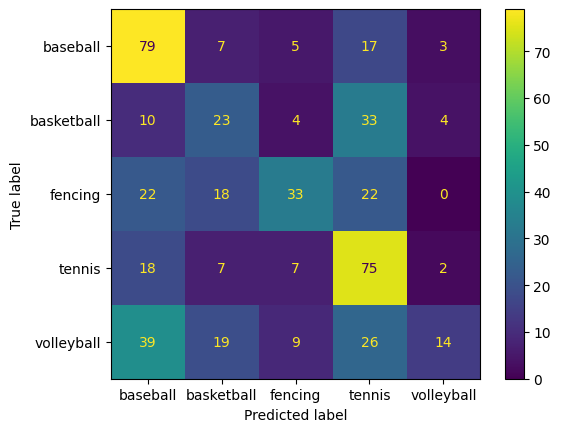

In [ ]:
# data for testing
# reference: https://stackoverflow.com/questions/53949991/get-true-labels-from-keras-generator

y_pred=added_vgg16_model.predict(test_ds)

#Testing Predict
true_labels = test_ds.classes
y_true = true_labels
y_pred = np.argmax(y_pred, axis=1)
labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

print('Testing Confusion Matrix')
dispay_confusion.plot()
print('Testing Classification Report')
print(classification_report(y_true, y_pred))

458/458 [==============================] - 32s 70ms/step
Training Classification Report
              precision    recall  f1-score   support

           0       0.63      0.51      0.57       512
           1       0.47      0.34      0.40       343
           2       0.49      0.38      0.43       438
           3       0.41      0.67      0.51       502
           4       0.37      0.35      0.36       494

    accuracy                           0.46      2289
   macro avg       0.47      0.45      0.45      2289
weighted avg       0.48      0.46      0.46      2289



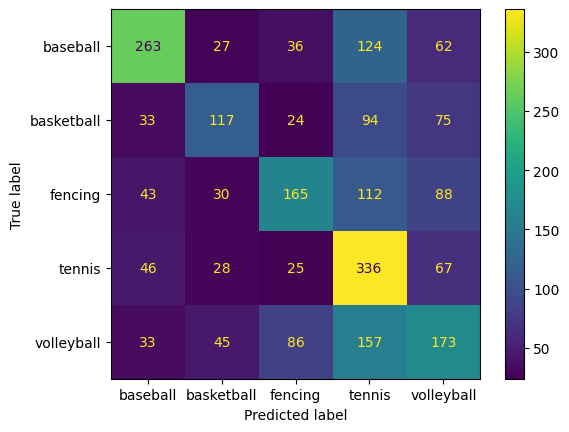

In [ ]:
#Training Predict
# reference: https://stackoverflow.com/questions/53949991/get-true-labels-from-keras-generator

y_pred=added_vgg16_model.predict(train_ds)

true_labels = train_ds.classes
y_true = true_labels
y_pred = np.argmax(y_pred, axis=1)
labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

dispay_confusion.plot()
print('Training Classification Report')
print(classification_report(y_true, y_pred))

In [ ]:
y_pred_test =added_vgg16_model.evaluate(test_ds)


print("Loss for Test",y_pred_test[0])
print("Accuracy for Test",y_pred_test[1])

100/100 [==============================] - 3s 32ms/step - loss: 33.9673 - accuracy: 0.4516
Loss for Test 33.967323303222656
Accuracy for Test 0.4516128897666931


### ResNet50

In [ ]:
# now looking at resnet50

tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet')


resnet50_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

# # getting all layers but last one 

# # Freezing the laters  
for layer in resnet50_model.layers:
    layer.trainable = False

x = resnet50_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x) 
added_resnet50_model = Model(inputs=resnet50_model.input, outputs=x)

# Make sure you have frozen the correct layers
print("Layers that are frozen vs not")
print('')
print('')
for i, layer in enumerate(added_resnet50_model.layers):
    print(i, layer.name, layer.trainable)

# # setting up the optimization of our weights 
added_resnet50_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr= 5e-5), metrics=["accuracy"])

94765736/94765736 [==============================] - 4s 0us/step


Layers that are frozen vs not


0 input_4 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=12)

history_resnet50_model = added_resnet50_model.fit_generator(train_ds,
                    validation_data = validation_ds,
                    epochs=100,callbacks=[callback]
)

Epoch 1/100


<ipython-input-20-2647407ba691>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_resnet50_model = added_resnet50_model.fit_generator(train_ds,


458/458 [==============================] - 41s 80ms/step - loss: 30.5034 - accuracy: 0.3028 - val_loss: 48.1502 - val_accuracy: 0.3210
Epoch 2/100
458/458 [==============================] - 35s 76ms/step - loss: 14.0824 - accuracy: 0.3844 - val_loss: 24.4740 - val_accuracy: 0.3827
Epoch 3/100
458/458 [==============================] - 35s 76ms/step - loss: 4.8484 - accuracy: 0.5146 - val_loss: 9.6284 - val_accuracy: 0.4794
Epoch 4/100
458/458 [==============================] - 35s 76ms/step - loss: 2.1263 - accuracy: 0.5430 - val_loss: 5.6269 - val_accuracy: 0.5082
Epoch 5/100
458/458 [==============================] - 35s 76ms/step - loss: 1.4152 - accuracy: 0.5692 - val_loss: 6.8166 - val_accuracy: 0.4424
Epoch 6/100
458/458 [==============================] - 35s 76ms/step - loss: 1.1708 - accuracy: 0.5898 - val_loss: 4.8459 - val_accuracy: 0.5494
Epoch 7/100
458/458 [==============================] - 35s 75ms/step - loss: 1.1801 - accuracy: 0.5972 - val_loss: 4.6383 - val_accuracy: 

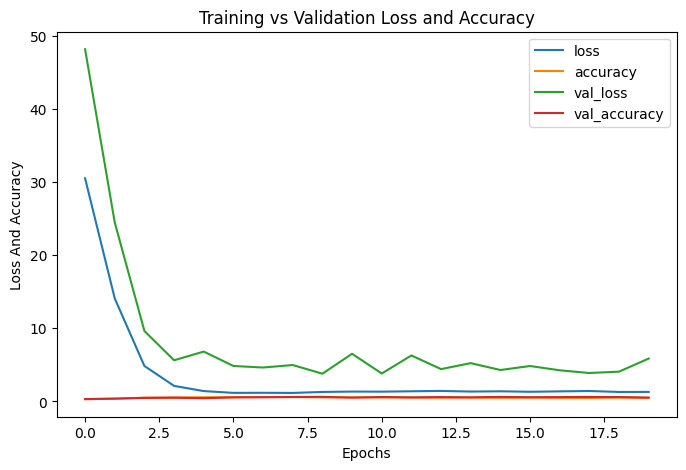

In [ ]:
# reference: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
pd.DataFrame(history_resnet50_model.history).plot(figsize=(8,5))
plt.xlabel('Epochs')
plt.ylabel('Loss And Accuracy')
plt.title('Training vs Validation Loss and Accuracy')
plt.show()


100/100 [==============================] - 3s 21ms/step
Testing Confusion Matrix
Testing Classification Report
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       111
           1       0.46      0.47      0.47        74
           2       0.77      0.39      0.52        95
           3       0.46      0.90      0.61       109
           4       0.83      0.42      0.56       107

    accuracy                           0.58       496
   macro avg       0.64      0.56      0.56       496
weighted avg       0.65      0.58      0.57       496



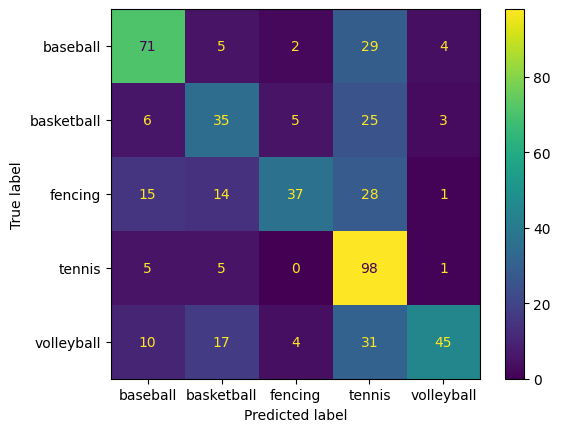

In [ ]:
# data for testing
# reference: https://stackoverflow.com/questions/53949991/get-true-labels-from-keras-generator


y_pred=added_resnet50_model.predict(test_ds)

#Testing Predict
true_labels = test_ds.classes
y_true = true_labels
y_pred = np.argmax(y_pred, axis=1)
labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

print('Testing Confusion Matrix')
dispay_confusion.plot()
print('Testing Classification Report')
print(classification_report(y_true, y_pred))


458/458 [==============================] - 32s 70ms/step
Training Classification Report
              precision    recall  f1-score   support

           0       0.52      0.42      0.46       512
           1       0.30      0.53      0.39       343
           2       0.51      0.36      0.42       438
           3       0.38      0.56      0.45       502
           4       0.52      0.26      0.34       494

    accuracy                           0.42      2289
   macro avg       0.45      0.42      0.41      2289
weighted avg       0.45      0.42      0.41      2289



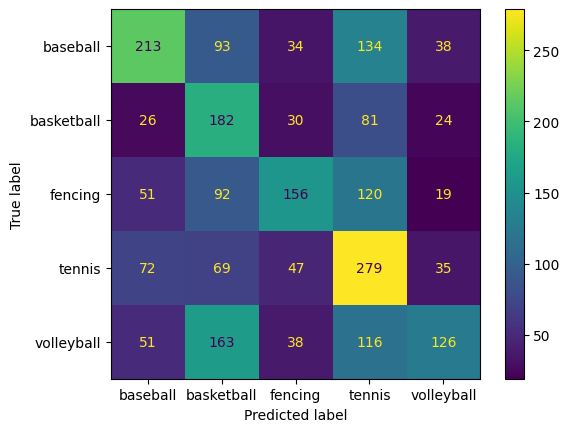

In [ ]:
#Training Predict

y_pred=added_resnet50_model.predict(train_ds)

true_labels = train_ds.classes
y_true = true_labels
y_pred = np.argmax(y_pred, axis=1)
labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

dispay_confusion.plot()
print('Training Classification Report')
print(classification_report(y_true, y_pred))

In [ ]:
y_pred_test =added_resnet50_model.evaluate(test_ds)


print("Loss for Test",y_pred_test[0])
print("Accuracy for Test",y_pred_test[1])

100/100 [==============================] - 2s 24ms/step - loss: 5.3075 - accuracy: 0.5766
Loss for Test 5.307534694671631
Accuracy for Test 0.5766128897666931


### EfficientNetB0

In [ ]:
# now looking at efficientnet



efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

# # getting all layers but last one 

# # Freezing the laters  
for layer in efficientnet_model.layers:
    layer.trainable = False

x = efficientnet_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x) 
added_efficientnet_model = Model(inputs=efficientnet_model.input, outputs=x)

# Make sure you have frozen the correct layers
print("Layers that are frozen vs not")
print('')
print('')
for i, layer in enumerate(added_efficientnet_model.layers):
    print(i, layer.name, layer.trainable)

# # setting up the optimization of our weights 
added_efficientnet_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr= 5e-5), metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step
Layers that are frozen vs not


0 input_5 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 bl

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=14)

history_efficientnet_model = added_efficientnet_model.fit_generator(train_ds,
                    validation_data = validation_ds,
                    epochs=100,callbacks=[callback]
)

Epoch 1/100


<ipython-input-26-18f7600af288>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_efficientnet_model = added_efficientnet_model.fit_generator(train_ds,


458/458 [==============================] - 43s 79ms/step - loss: 18.7545 - accuracy: 0.3233 - val_loss: 16.0303 - val_accuracy: 0.4362
Epoch 2/100
458/458 [==============================] - 34s 74ms/step - loss: 7.8975 - accuracy: 0.4941 - val_loss: 7.7436 - val_accuracy: 0.5226
Epoch 3/100
458/458 [==============================] - 33s 73ms/step - loss: 3.2896 - accuracy: 0.5928 - val_loss: 2.5217 - val_accuracy: 0.6667
Epoch 4/100
458/458 [==============================] - 34s 73ms/step - loss: 1.5617 - accuracy: 0.6636 - val_loss: 1.9543 - val_accuracy: 0.6749
Epoch 5/100
458/458 [==============================] - 34s 74ms/step - loss: 0.9824 - accuracy: 0.7125 - val_loss: 1.6146 - val_accuracy: 0.6893
Epoch 6/100
458/458 [==============================] - 35s 76ms/step - loss: 0.8662 - accuracy: 0.7300 - val_loss: 1.6402 - val_accuracy: 0.7160
Epoch 7/100
458/458 [==============================] - 34s 74ms/step - loss: 0.8457 - accuracy: 0.7444 - val_loss: 1.2599 - val_accuracy: 0.

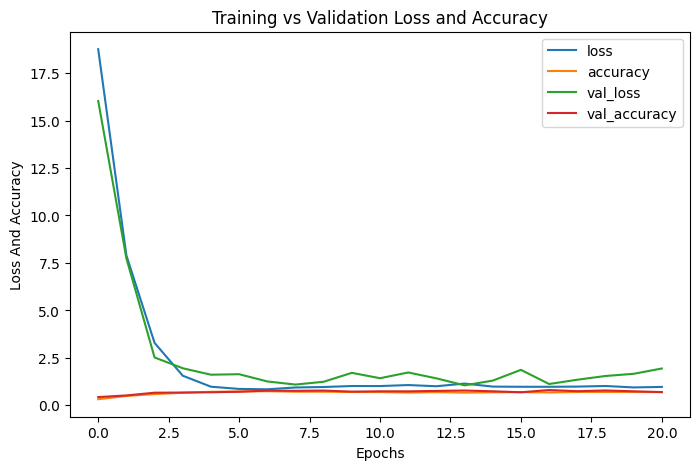

In [ ]:
# reference: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
pd.DataFrame(history_efficientnet_model.history).plot(figsize=(8,5))
plt.xlabel('Epochs')
plt.ylabel('Loss And Accuracy')
plt.title('Training vs Validation Loss and Accuracy')
plt.show()


100/100 [==============================] - 4s 20ms/step
Testing Confusion Matrix
Testing Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       111
           1       0.89      0.32      0.48        74
           2       0.93      0.56      0.70        95
           3       0.70      0.90      0.79       109
           4       0.65      0.91      0.75       107

    accuracy                           0.75       496
   macro avg       0.80      0.72      0.72       496
weighted avg       0.79      0.75      0.73       496



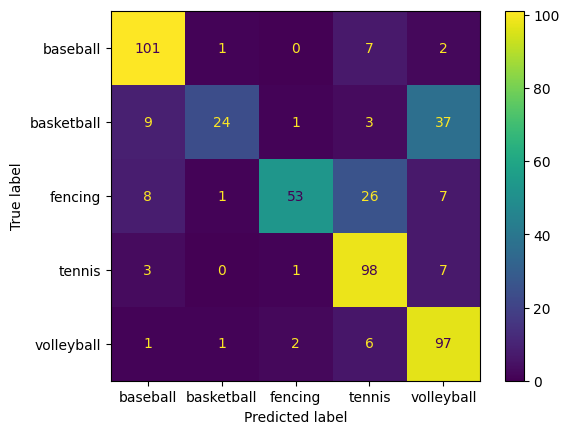

In [ ]:
# data for testing
# reference: https://stackoverflow.com/questions/53949991/get-true-labels-from-keras-generator


y_pred=added_efficientnet_model.predict(test_ds)

#Testing Predict
true_labels = test_ds.classes
y_true = true_labels
y_pred = np.argmax(y_pred, axis=1)
labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

print('Testing Confusion Matrix')
dispay_confusion.plot()
print('Testing Classification Report')
print(classification_report(y_true, y_pred))


458/458 [==============================] - 33s 73ms/step
Training Classification Report
              precision    recall  f1-score   support

           0       0.50      0.66      0.57       512
           1       0.69      0.35      0.47       343
           2       0.62      0.37      0.46       438
           3       0.54      0.66      0.59       502
           4       0.53      0.62      0.57       494

    accuracy                           0.55      2289
   macro avg       0.58      0.53      0.53      2289
weighted avg       0.57      0.55      0.54      2289



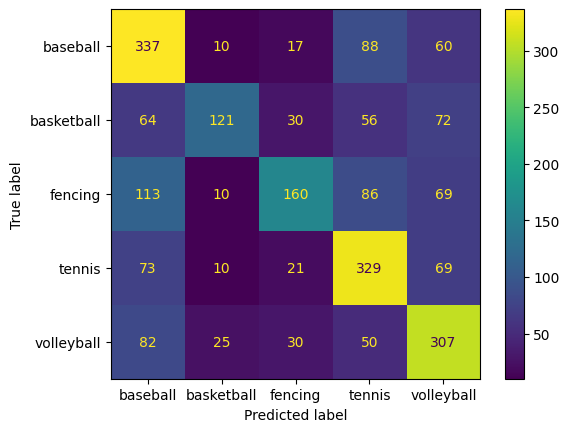

In [ ]:
#Training Predict
# reference: https://stackoverflow.com/questions/53949991/get-true-labels-from-keras-generator


y_pred=added_efficientnet_model.predict(train_ds)

true_labels = train_ds.classes
y_true = true_labels
y_pred = np.argmax(y_pred, axis=1)
labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

dispay_confusion.plot()
print('Training Classification Report')
print(classification_report(y_true, y_pred))

In [ ]:
y_pred_test =added_efficientnet_model.evaluate(test_ds)


print("Loss for Test",y_pred_test[0])
print("Accuracy for Test",y_pred_test[1])

100/100 [==============================] - 2s 19ms/step - loss: 1.5200 - accuracy: 0.7520
Loss for Test 1.5199675559997559
Accuracy for Test 0.7520161271095276


# Part 2 

**Transfer Learning in Videos**
1. I first re-trained the models using the same seed in the split but using the validation/training data combined and testing set as the validation set (for early stopping). This way we use the validation and testing set to retrain the model without overfitting.
2. I then read in all the videos and used them as a testing set.
3. I used used 100 frames to predict/classify the video and and reported the Confusion Matrix, Precision, Recall, Accuracy, and F1 score

In [ ]:
# !pip install split-folders
# import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/dsci552_finalproject/images/Sport Images', output="/content/drive/MyDrive/dsci552_finalproject/video_data", seed=1337, ratio=(.85,.15)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3302 files [01:02, 53.02 files/s] 


In [ ]:
!unzip video_train.zip -d v_train
!unzip video_test.zip -d v_test

Archive:  video_train.zip
replace v_train/train/baseball/00000777.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  video_test.zip
replace v_test/val/fencing/00000331.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
seed_train_validation = 1 # Must be same for train_ds and val_ds



train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.1,1.0],rotation_range=30, horizontal_flip=True, vertical_flip=True,brightness_range=[0.1,1.5],width_shift_range = 0.1,height_shift_range = 0.1)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


train_ds = train_datagen.flow_from_directory(
directory ="/content/v_train/train",
target_size = (224, 224),
batch_size =5,
shuffle = False,
seed = seed_train_validation)

validation_ds = validation_datagen.flow_from_directory(
directory ="/content/v_test/val",
target_size = (224, 224),
batch_size =5,
shuffle = False,
seed = seed_train_validation)

Found 2788 images belonging to 5 classes.
Found 496 images belonging to 5 classes.


In [ ]:
# Not using training data and using previous amount of epochs

vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

# # getting all layers but last one 

# # Freezing the laters  
for layer in vgg16_model.layers:
    layer.trainable = False

    

x = vgg16_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x) 
added_vgg16_model = Model(inputs=vgg16_model.input, outputs=x)

# Make sure you have frozen the correct layers
print("Layers that are frozen vs not")
print('')
print('')
for i, layer in enumerate(added_vgg16_model.layers):
    print(i, layer.name, layer.trainable)

# # setting up the optimization of our weights 
added_vgg16_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr= 5e-5), metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=12)

history_vgg16_model = added_vgg16_model.fit_generator(train_ds,
                    validation_data = validation_ds,
                    epochs=100,callbacks=[callback]
)

Layers that are frozen vs not


0 input_6 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_4 True
20 batch_normalization_4 True
21 dense_8 True
22 dropout_4 True
23 dense_9 True
Epoch 1/100


<ipython-input-39-e9c16bb3d061>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg16_model = added_vgg16_model.fit_generator(train_ds,


558/558 [==============================] - 47s 80ms/step - loss: 5.3564 - accuracy: 0.3128 - val_loss: 11.5804 - val_accuracy: 0.3387
Epoch 2/100
558/558 [==============================] - 45s 80ms/step - loss: 1.7017 - accuracy: 0.4670 - val_loss: 5.2208 - val_accuracy: 0.4839
Epoch 3/100
558/558 [==============================] - 46s 82ms/step - loss: 1.1177 - accuracy: 0.5793 - val_loss: 5.5572 - val_accuracy: 0.4698
Epoch 4/100
558/558 [==============================] - 43s 77ms/step - loss: 1.0997 - accuracy: 0.5915 - val_loss: 4.2411 - val_accuracy: 0.5847
Epoch 5/100
558/558 [==============================] - 43s 78ms/step - loss: 1.0703 - accuracy: 0.6087 - val_loss: 6.8061 - val_accuracy: 0.4556
Epoch 6/100
558/558 [==============================] - 43s 77ms/step - loss: 1.0531 - accuracy: 0.6306 - val_loss: 5.2920 - val_accuracy: 0.5766
Epoch 7/100
558/558 [==============================] - 42s 76ms/step - loss: 1.1029 - accuracy: 0.5972 - val_loss: 6.9323 - val_accuracy: 0.5

In [ ]:
# now looking at resnet50 using same amount of epochs

tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet')


resnet50_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

# # getting all layers but last one 

# # Freezing the laters  
for layer in resnet50_model.layers:
    layer.trainable = False

x = resnet50_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x) 
added_resnet50_model = Model(inputs=resnet50_model.input, outputs=x)

# Make sure you have frozen the correct layers
print("Layers that are frozen vs not")
print('')
print('')
for i, layer in enumerate(added_resnet50_model.layers):
    print(i, layer.name, layer.trainable)

# # setting up the optimization of our weights 
added_resnet50_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr= 5e-5), metrics=["accuracy"])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=12)

history_resnet50_model = added_resnet50_model.fit_generator(train_ds,
                    validation_data = validation_ds,
                    epochs=100,callbacks=[callback]
)

Layers that are frozen vs not


0 input_4 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv

<ipython-input-4-9c40e06db047>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_resnet50_model = added_resnet50_model.fit_generator(train_ds,


558/558 [==============================] - 52s 81ms/step - loss: 28.4279 - accuracy: 0.2887 - val_loss: 32.1587 - val_accuracy: 0.3085
Epoch 2/100
558/558 [==============================] - 42s 76ms/step - loss: 10.2174 - accuracy: 0.4146 - val_loss: 10.3340 - val_accuracy: 0.4113
Epoch 3/100
558/558 [==============================] - 42s 76ms/step - loss: 2.9556 - accuracy: 0.5176 - val_loss: 4.8982 - val_accuracy: 0.4960
Epoch 4/100
558/558 [==============================] - 43s 76ms/step - loss: 1.4334 - accuracy: 0.5603 - val_loss: 3.0821 - val_accuracy: 0.5524
Epoch 5/100
558/558 [==============================] - 42s 75ms/step - loss: 1.2017 - accuracy: 0.5843 - val_loss: 3.0358 - val_accuracy: 0.5363
Epoch 6/100
558/558 [==============================] - 42s 76ms/step - loss: 1.1587 - accuracy: 0.6051 - val_loss: 4.5653 - val_accuracy: 0.5323
Epoch 7/100
558/558 [==============================] - 43s 76ms/step - loss: 1.2345 - accuracy: 0.5846 - val_loss: 2.5438 - val_accuracy: 

In [ ]:
# now looking at efficientnet



efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

# # getting all layers but last one 

# # Freezing the laters  
for layer in efficientnet_model.layers:
    layer.trainable = False

x = efficientnet_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x) 
added_efficientnet_model = Model(inputs=efficientnet_model.input, outputs=x)

# Make sure you have frozen the correct layers
print("Layers that are frozen vs not")
print('')
print('')
for i, layer in enumerate(added_efficientnet_model.layers):
    print(i, layer.name, layer.trainable)

# # setting up the optimization of our weights 
added_efficientnet_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr= 5e-5), metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=14)

history_efficientnet_model = added_efficientnet_model.fit_generator(train_ds,
                    validation_data = validation_ds,
                    epochs=100,callbacks=[callback]
)

Layers that are frozen vs not


0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation Fals

<ipython-input-4-856b31708b0d>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_efficientnet_model = added_efficientnet_model.fit_generator(train_ds,


558/558 [==============================] - 54s 80ms/step - loss: 16.5488 - accuracy: 0.3540 - val_loss: 10.2469 - val_accuracy: 0.4778
Epoch 2/100
558/558 [==============================] - 43s 77ms/step - loss: 5.0002 - accuracy: 0.5348 - val_loss: 2.0724 - val_accuracy: 0.7198
Epoch 3/100
558/558 [==============================] - 42s 76ms/step - loss: 1.7243 - accuracy: 0.6585 - val_loss: 1.4177 - val_accuracy: 0.7399
Epoch 4/100
558/558 [==============================] - 42s 75ms/step - loss: 1.0910 - accuracy: 0.6951 - val_loss: 1.3559 - val_accuracy: 0.7077
Epoch 5/100
558/558 [==============================] - 43s 77ms/step - loss: 0.9431 - accuracy: 0.7113 - val_loss: 1.0792 - val_accuracy: 0.7621
Epoch 6/100
558/558 [==============================] - 42s 75ms/step - loss: 0.9395 - accuracy: 0.7145 - val_loss: 1.0285 - val_accuracy: 0.7762
Epoch 7/100
558/558 [==============================] - 42s 75ms/step - loss: 1.0034 - accuracy: 0.6912 - val_loss: 1.0589 - val_accuracy: 0.

In [ ]:
# reference: https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/
def prediction_frames(video, model):
  videos = cv2.VideoCapture(video)
  print(videos)
  (W, H) = (None, None)
  prediction = []
  frames = []
  counter = 0 
  while(True):

      # Reading each frame in a video
      (grabbed, frame) = videos.read()
      counter+=1

      # breaking at the end of each video
      if not grabbed:
        break
      if counter <=100:
        # getting frame width
        if W is None or H is None:
          (H, W) = frame.shape[:2]
          output = frame.copy()
        
        # Turning the frame into something readable  
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))

        # creating a prediction based off the model 
        preds = model.predict(np.expand_dims(frame, axis=0))[0]
        print(counter)
          
        # appending all the predicitons together
        prediction.append(preds)

  # taking a mean of the predictions
  results = np.array(prediction).mean(axis=0)
  #finding the highest mean
  predicted_result = np.argmax(results)
  return predicted_result

In [ ]:

def total_prediction(model):
  total_pred = []
  total_true = []
  list_of_folders = ['BaseballPitch','Basketball','Fencing','TennisSwing','VolleyballSpiking']
  for folder in list_of_folders:
    for video in os.listdir(f"/content/drive/MyDrive/dsci552_finalproject/images/Sport Videos/{folder}"):
      if folder == 'BaseballPitch':
        y_pred = prediction_frames(f"/content/drive/MyDrive/dsci552_finalproject/images/Sport Videos/{folder}/{video}",model)
        y_true = 0
        total_pred.append(y_pred)
        total_true.append(y_true)
        print("video in", folder, 'is done!')
      elif folder == 'Basketball':
        y_pred = prediction_frames(f"/content/drive/MyDrive/dsci552_finalproject/images/Sport Videos/{folder}/{video}",model)
        y_true = 1
        total_pred.append(y_pred)
        total_true.append(y_true)
        print("video in", folder, 'is done!')
      elif folder == 'Fencing':
        y_pred = prediction_frames(f"/content/drive/MyDrive/dsci552_finalproject/images/Sport Videos/{folder}/{video}",model)
        y_true = 2
        total_pred.append(y_pred)
        total_true.append(y_true)
      elif folder == 'TennisSwing':
        y_pred = prediction_frames(f"/content/drive/MyDrive/dsci552_finalproject/images/Sport Videos/{folder}/{video}",model)
        y_true = 3
        total_pred.append(y_pred)
        total_true.append(y_true)
        print("video in", folder, 'is done!')
      else:
        y_pred = prediction_frames(f"/content/drive/MyDrive/dsci552_finalproject/images/Sport Videos/{folder}/{video}",model)
        y_true = 4
        total_pred.append(y_pred)
        total_true.append(y_true)
        print("video in", folder, 'is done!')
  return total_pred,total_true


In [ ]:
video_vgg16_model = total_prediction(added_vgg16_model)

Streaming output truncated to the last 5000 lines.
67
1/1 [==============================] - 0s 23ms/step
68
1/1 [==============================] - 0s 22ms/step
69
1/1 [==============================] - 0s 22ms/step
70
1/1 [==============================] - 0s 20ms/step
71
1/1 [==============================] - 0s 25ms/step
72
1/1 [==============================] - 0s 22ms/step
73
1/1 [==============================] - 0s 21ms/step
74
1/1 [==============================] - 0s 20ms/step
75
1/1 [==============================] - 0s 21ms/step
76
1/1 [==============================] - 0s 23ms/step
77
1/1 [==============================] - 0s 21ms/step
78
1/1 [==============================] - 0s 22ms/step
79
1/1 [==============================] - 0s 21ms/step
80
1/1 [==============================] - 0s 20ms/step
81
1/1 [==============================] - 0s 22ms/step
82
1/1 [==============================] - 0s 20ms/step
83
1/1 [==============================] - 0s 21ms/step
84
1/1 [======

Training Classification Report
              precision    recall  f1-score   support

           0       0.40      0.93      0.56       150
           1       0.14      0.07      0.10       137
           2       1.00      0.01      0.02       112
           3       0.33      0.44      0.38       169
           4       0.38      0.14      0.20       116

    accuracy                           0.35       684
   macro avg       0.45      0.32      0.25       684
weighted avg       0.43      0.35      0.27       684



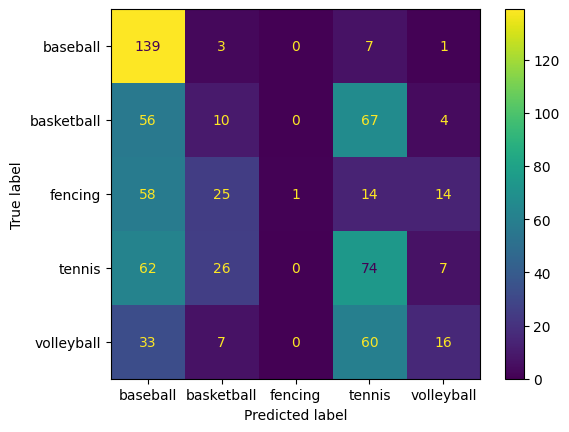

In [ ]:
# v166 model
y_pred= video_vgg16_model[0]
y_true = video_vgg16_model[1]

labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

dispay_confusion.plot()
print('Training Classification Report')
print(classification_report(y_true, y_pred))

In [ ]:
video_resnet50_model = total_prediction(added_resnet50_model)

Streaming output truncated to the last 5000 lines.
67
1/1 [==============================] - 0s 24ms/step
68
1/1 [==============================] - 0s 22ms/step
69
1/1 [==============================] - 0s 23ms/step
70
1/1 [==============================] - 0s 24ms/step
71
1/1 [==============================] - 0s 23ms/step
72
1/1 [==============================] - 0s 25ms/step
73
1/1 [==============================] - 0s 26ms/step
74
1/1 [==============================] - 0s 25ms/step
75
1/1 [==============================] - 0s 26ms/step
76
1/1 [==============================] - 0s 25ms/step
77
1/1 [==============================] - 0s 25ms/step
78
1/1 [==============================] - 0s 29ms/step
79
1/1 [==============================] - 0s 25ms/step
80
1/1 [==============================] - 0s 24ms/step
81
1/1 [==============================] - 0s 27ms/step
82
1/1 [==============================] - 0s 26ms/step
83
1/1 [==============================] - 0s 28ms/step
84
1/1 [======

Training Classification Report
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       150
           1       0.12      0.01      0.03       137
           2       0.48      0.47      0.48       112
           3       0.40      0.91      0.56       169
           4       0.50      0.08      0.13       116

    accuracy                           0.50       684
   macro avg       0.46      0.46      0.40       684
weighted avg       0.46      0.50      0.43       684



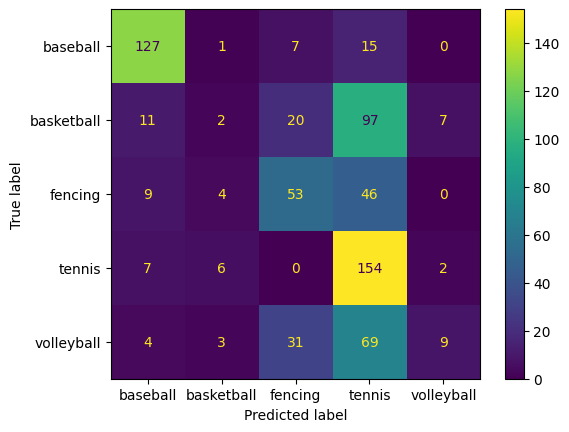

In [ ]:
# resnet model
y_pred= video_resnet50_model[0]
y_true = video_resnet50_model[1]

labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

dispay_confusion.plot()
print('Training Classification Report')
print(classification_report(y_true, y_pred))

In [ ]:
video_efficientnet_model = total_prediction(added_efficientnet_model)

Streaming output truncated to the last 5000 lines.
67
1/1 [==============================] - 0s 24ms/step
68
1/1 [==============================] - 0s 27ms/step
69
1/1 [==============================] - 0s 26ms/step
70
1/1 [==============================] - 0s 29ms/step
71
1/1 [==============================] - 0s 28ms/step
72
1/1 [==============================] - 0s 27ms/step
73
1/1 [==============================] - 0s 27ms/step
74
1/1 [==============================] - 0s 28ms/step
75
1/1 [==============================] - 0s 29ms/step
76
1/1 [==============================] - 0s 27ms/step
77
1/1 [==============================] - 0s 30ms/step
78
1/1 [==============================] - 0s 27ms/step
79
1/1 [==============================] - 0s 29ms/step
80
1/1 [==============================] - 0s 33ms/step
81
1/1 [==============================] - 0s 27ms/step
82
1/1 [==============================] - 0s 25ms/step
83
1/1 [==============================] - 0s 24ms/step
84
1/1 [======

Training Classification Report
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       150
           1       0.33      0.01      0.01       137
           2       0.25      0.40      0.31       112
           3       0.42      0.71      0.53       169
           4       0.83      0.21      0.33       116

    accuracy                           0.46       684
   macro avg       0.50      0.43      0.39       684
weighted avg       0.50      0.46      0.40       684



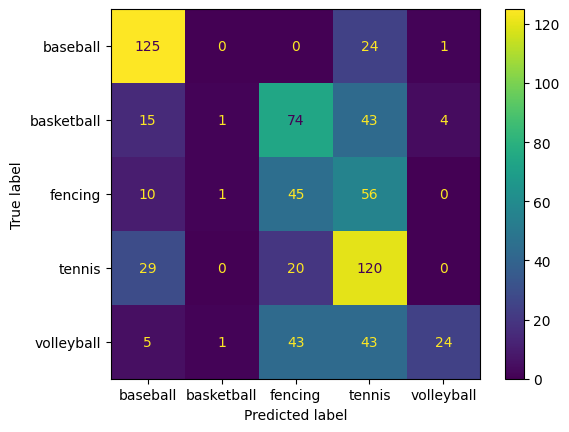

In [ ]:
# efficientnet model 
y_pred= video_efficientnet_model[0]
y_true = video_efficientnet_model[1]

labels = ['baseball','basketball','fencing','tennis','volleyball']
dispay_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)

dispay_confusion.plot()
print('Training Classification Report')
print(classification_report(y_true, y_pred))